#Part 1

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from statsmodels.graphics import tsaplots
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
from prophet import Prophet
from prophet.plot import plot_components

In [4]:
df = pd.read_csv('/content/Weather_Data_1980_2024(hourly).csv')
df.head()

,time,temperature,relative_humidity,dew_point,precipitation (mm),rain (mm),snowfall (cm),pressure_msl (hPa),surface_pressure (hPa),cloud_cover (%),cloud_cover_low (%),cloud_cover_mid (%),cloud_cover_high (%),vapour_pressure_deficit (kPa),wind_speed_10m (km/h),wind_direction,is_Day
0,1980-01-01T00:00,12.7,83,10.0,0.0,0.0,0,1012.8,945.1,1,1,0,0,0.25,7.5,235,0
1,1980-01-01T01:00,12.9,82,9.9,0.0,0.0,0,1012.2,944.5,4,4,0,0,0.26,7.9,231,0
2,1980-01-01T02:00,13.2,82,10.2,0.0,0.0,0,1012.3,944.7,13,14,0,0,0.27,7.5,235,1
3,1980-01-01T03:00,15.9,78,12.0,0.0,0.0,0,1013.5,946.4,23,26,0,0,0.40,6.6,248,1
4,1980-01-01T04:00,19.4,67,13.1,0.0,0.0,0,1014.6,948.2,9,10,0,0,0.75,8.7,265,1


In [5]:
# Convert to datetime
df['timestamp'] = pd.to_datetime(df['time'])

# Extract date and hour
df['date'] = df['timestamp'].dt.date
df['hour'] = df['timestamp'].dt.time  # or use .dt.hour for just the hour number
df.drop('time', axis=1, inplace=True)
df.head()

,temperature,relative_humidity,dew_point,precipitation (mm),rain (mm),snowfall (cm),pressure_msl (hPa),surface_pressure (hPa),cloud_cover (%),cloud_cover_low (%),cloud_cover_mid (%),cloud_cover_high (%),vapour_pressure_deficit (kPa),wind_speed_10m (km/h),wind_direction,is_Day,timestamp,date,hour
0,12.7,83,10.0,0.0,0.0,0,1012.8,945.1,1,1,0,0,0.25,7.5,235,0,1980-01-01 00:00:00,1980-01-01,00:00:00
1,12.9,82,9.9,0.0,0.0,0,1012.2,944.5,4,4,0,0,0.26,7.9,231,0,1980-01-01 01:00:00,1980-01-01,01:00:00
2,13.2,82,10.2,0.0,0.0,0,1012.3,944.7,13,14,0,0,0.27,7.5,235,1,1980-01-01 02:00:00,1980-01-01,02:00:00
3,15.9,78,12.0,0.0,0.0,0,1013.5,946.4,23,26,0,0,0.40,6.6,248,1,1980-01-01 03:00:00,1980-01-01,03:00:00
4,19.4,67,13.1,0.0,0.0,0,1014.6,948.2,9,10,0,0,0.75,8.7,265,1,1980-01-01 04:00:00,1980-01-01,04:00:00


In [6]:
# Group by date and calculate mean of numeric columns
daily_mean = df.groupby('date').mean(numeric_only=True).reset_index()

daily_mean.head()

,date,temperature,relative_humidity,dew_point,precipitation (mm),rain (mm),snowfall (cm),pressure_msl (hPa),surface_pressure (hPa),cloud_cover (%),cloud_cover_low (%),cloud_cover_mid (%),cloud_cover_high (%),vapour_pressure_deficit (kPa),wind_speed_10m (km/h),wind_direction,is_Day
0,1980-01-01,19.616667,71.041667,13.591667,0.0,0.0,0.0,1012.670833,946.462500,39.291667,38.125000,17.958333,0.083333,0.765833,8.833333,261.541667,0.458333
1,1980-01-02,18.925000,69.041667,12.145833,0.0,0.0,0.0,1013.183333,946.804167,16.708333,18.583333,0.000000,0.000000,0.799167,7.770833,247.708333,0.458333
2,1980-01-03,18.783333,57.583333,9.441667,0.0,0.0,0.0,1013.666667,947.237500,2.708333,2.833333,0.166667,0.000000,1.039167,6.112500,169.541667,0.458333
3,1980-01-04,20.475000,55.833333,10.983333,0.0,0.0,0.0,1013.733333,947.654167,17.000000,5.291667,20.458333,0.000000,1.152500,11.954167,86.125000,0.458333
4,1980-01-05,20.187500,72.625000,14.679167,0.0,0.0,0.0,1014.695833,948.483333,28.250000,10.375000,31.625000,0.000000,0.733750,11.416667,91.500000,0.458333


In [7]:
daily_mean['date'] = pd.to_datetime(daily_mean['date'])
daily_mean.set_index(daily_mean['date'], inplace=True)#change index to dates.
daily_mean.head()

,date,temperature,relative_humidity,dew_point,precipitation (mm),rain (mm),snowfall (cm),pressure_msl (hPa),surface_pressure (hPa),cloud_cover (%),cloud_cover_low (%),cloud_cover_mid (%),cloud_cover_high (%),vapour_pressure_deficit (kPa),wind_speed_10m (km/h),wind_direction,is_Day
date,,,,,,,,,,,,,,,,,
1980-01-01,1980-01-01,19.616667,71.041667,13.591667,0.0,0.0,0.0,1012.670833,946.462500,39.291667,38.125000,17.958333,0.083333,0.765833,8.833333,261.541667,0.458333
1980-01-02,1980-01-02,18.925000,69.041667,12.145833,0.0,0.0,0.0,1013.183333,946.804167,16.708333,18.583333,0.000000,0.000000,0.799167,7.770833,247.708333,0.458333
1980-01-03,1980-01-03,18.783333,57.583333,9.441667,0.0,0.0,0.0,1013.666667,947.237500,2.708333,2.833333,0.166667,0.000000,1.039167,6.112500,169.541667,0.458333
1980-01-04,1980-01-04,20.475000,55.833333,10.983333,0.0,0.0,0.0,1013.733333,947.654167,17.000000,5.291667,20.458333,0.000000,1.152500,11.954167,86.125000,0.458333
1980-01-05,1980-01-05,20.187500,72.625000,14.679167,0.0,0.0,0.0,1014.695833,948.483333,28.250000,10.375000,31.625000,0.000000,0.733750,11.416667,91.500000,0.458333


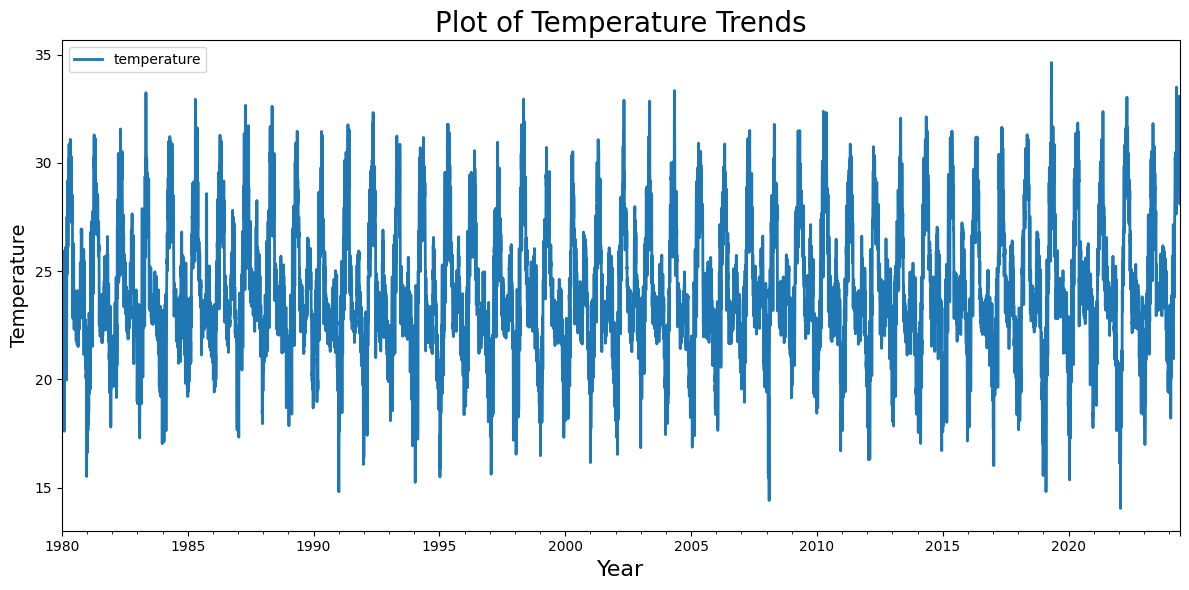

In [8]:
temperature = daily_mean[['temperature']]

# Plot
temperature.plot(figsize=(12,6), linewidth=2)
plt.title("Plot of Temperature Trends", fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Temperature', fontsize=14)
plt.tight_layout()
plt.show()

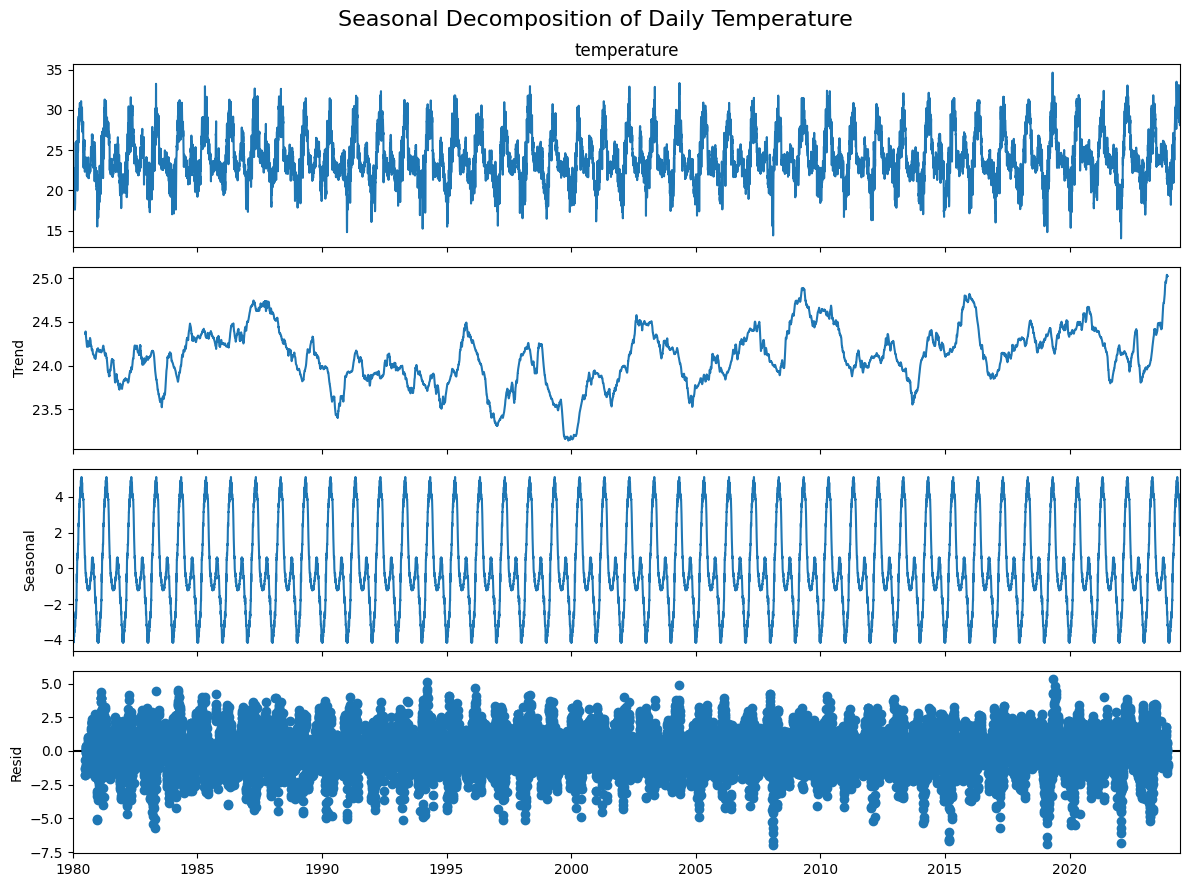

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(daily_mean['temperature'], model='additive', period=365)

plt.rcParams.update({'figure.figsize': (12, 9)})
result.plot()
plt.suptitle('Seasonal Decomposition of Daily Temperature', fontsize=16)
plt.tight_layout()
plt.show()

In [10]:
seasonal = result.seasonal

rng = (seasonal.max() - seasonal.min())
print(f"range: {rng:.2f}")

range: 9.27


In [11]:
daily_mean_csv = daily_mean.to_csv('daily_mean.csv')

##Data Preparation & Visualization

In [12]:
weekly_avg = daily_mean.resample('7D').mean()
weekly_avg_csv = weekly_avg.to_csv('weekly_avg.csv')
weekly_avg.head()

,date,temperature,relative_humidity,dew_point,precipitation (mm),rain (mm),snowfall (cm),pressure_msl (hPa),surface_pressure (hPa),cloud_cover (%),cloud_cover_low (%),cloud_cover_mid (%),cloud_cover_high (%),vapour_pressure_deficit (kPa),wind_speed_10m (km/h),wind_direction,is_Day
date,,,,,,,,,,,,,,,,,
1980-01-01,1980-01-04,20.014286,66.380952,12.883929,0.0,0.0,0.0,1014.290476,948.074405,26.422619,15.553571,22.113095,0.011905,0.889762,9.815476,150.434524,0.458333
1980-01-08,1980-01-11,21.902381,57.392857,12.410119,0.0,0.0,0.0,1014.598214,948.767857,14.994048,4.351190,18.410714,0.000000,1.249405,6.576190,184.755952,0.458333
1980-01-15,1980-01-18,22.090476,54.642857,11.555952,0.0,0.0,0.0,1015.789286,949.919048,0.815476,0.101190,1.214286,0.000000,1.381131,6.602976,165.994048,0.458333
1980-01-22,1980-01-25,20.632738,53.880952,9.634524,0.0,0.0,0.0,1013.648810,947.597619,1.779762,1.970238,0.000000,0.000000,1.328393,7.159524,204.113095,0.458333
1980-01-29,1980-02-01,19.214881,59.428571,9.879762,0.0,0.0,0.0,1013.060119,946.745238,8.494048,8.071429,1.994048,0.113095,1.075417,8.665476,222.172619,0.458333


In [13]:
weekly_avg.describe()

,date,temperature,relative_humidity,dew_point,precipitation (mm),rain (mm),snowfall (cm),pressure_msl (hPa),surface_pressure (hPa),cloud_cover (%),cloud_cover_low (%),cloud_cover_mid (%),cloud_cover_high (%),vapour_pressure_deficit (kPa),wind_speed_10m (km/h),wind_direction,is_Day
count,2319,2319.000000,2319.000000,2319.000000,2319.000000,2319.000000,2319.0,2319.000000,2319.000000,2319.000000,2319.000000,2319.000000,2319.000000,2319.000000,2319.000000,2319.000000,2319.000000
mean,2002-03-21 23:58:45.485122816,24.131932,63.947750,15.234844,0.114475,0.114475,0.0,1010.373297,945.282326,35.155853,24.283918,16.729544,30.095299,1.285848,10.992337,204.216953,0.507200
min,1980-01-04 00:00:00,16.654762,22.321429,1.291667,0.000000,0.000000,0.0,1000.327381,935.985714,0.000000,0.000000,0.000000,0.000000,0.095476,4.465476,64.809524,0.458333
25%,1991-02-11 12:00:00,22.412202,47.904762,10.287798,0.000000,0.000000,0.0,1007.476786,942.764286,5.883929,0.142857,2.074405,2.714286,0.474851,7.576786,154.351190,0.458333
50%,2002-03-22 00:00:00,23.645238,59.684524,15.250595,0.002976,0.002976,0.0,1010.497619,945.775000,15.779762,4.922619,10.130952,17.089286,1.276369,9.133929,230.833333,0.505952
75%,2013-04-29 12:00:00,25.880655,85.491071,21.036607,0.127381,0.127381,0.0,1013.565476,948.011012,73.351190,52.532738,24.991071,56.714286,1.803036,13.974107,252.791667,0.541667
max,2024-06-05 00:00:00,32.492857,96.410714,23.073810,3.009524,3.009524,0.0,1018.733929,952.049405,100.000000,90.511905,90.952381,99.053571,3.883274,25.449405,302.607143,0.541667
std,NaN,2.818253,19.614360,5.539694,0.242964,0.242964,0.0,3.800216,3.354849,35.837467,30.806093,18.514358,30.659152,0.812673,4.597643,61.021674,0.036223


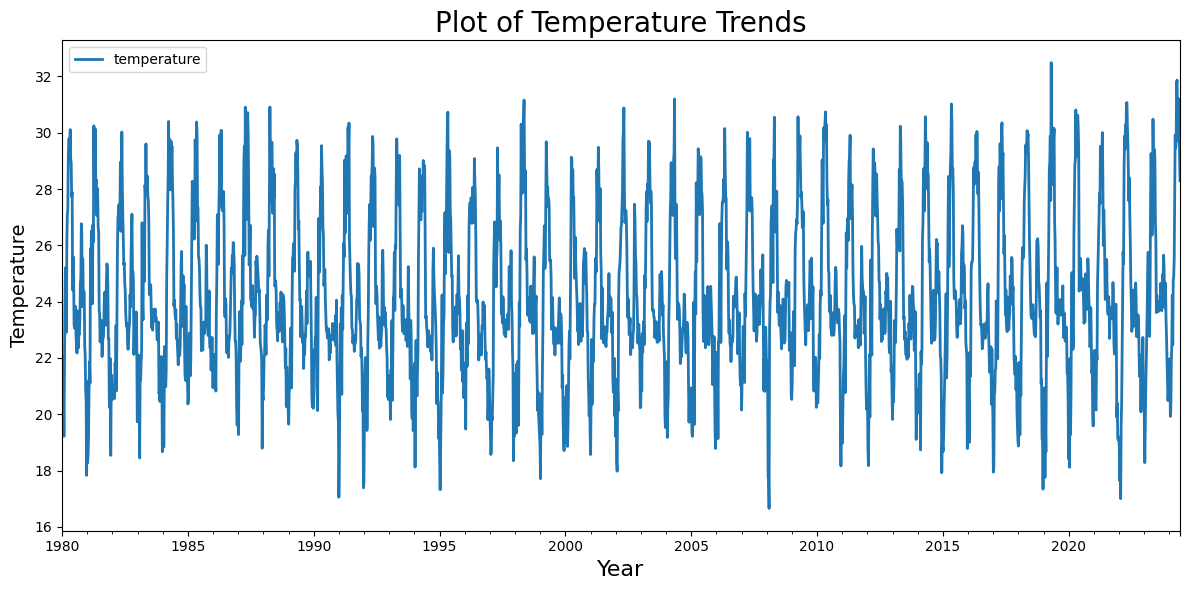

In [14]:
temperature = weekly_avg[['temperature']]

# Plot
temperature.plot(figsize=(12,6), linewidth=2)
plt.title("Plot of Temperature Trends", fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Temperature', fontsize=14)
plt.tight_layout()
plt.show()

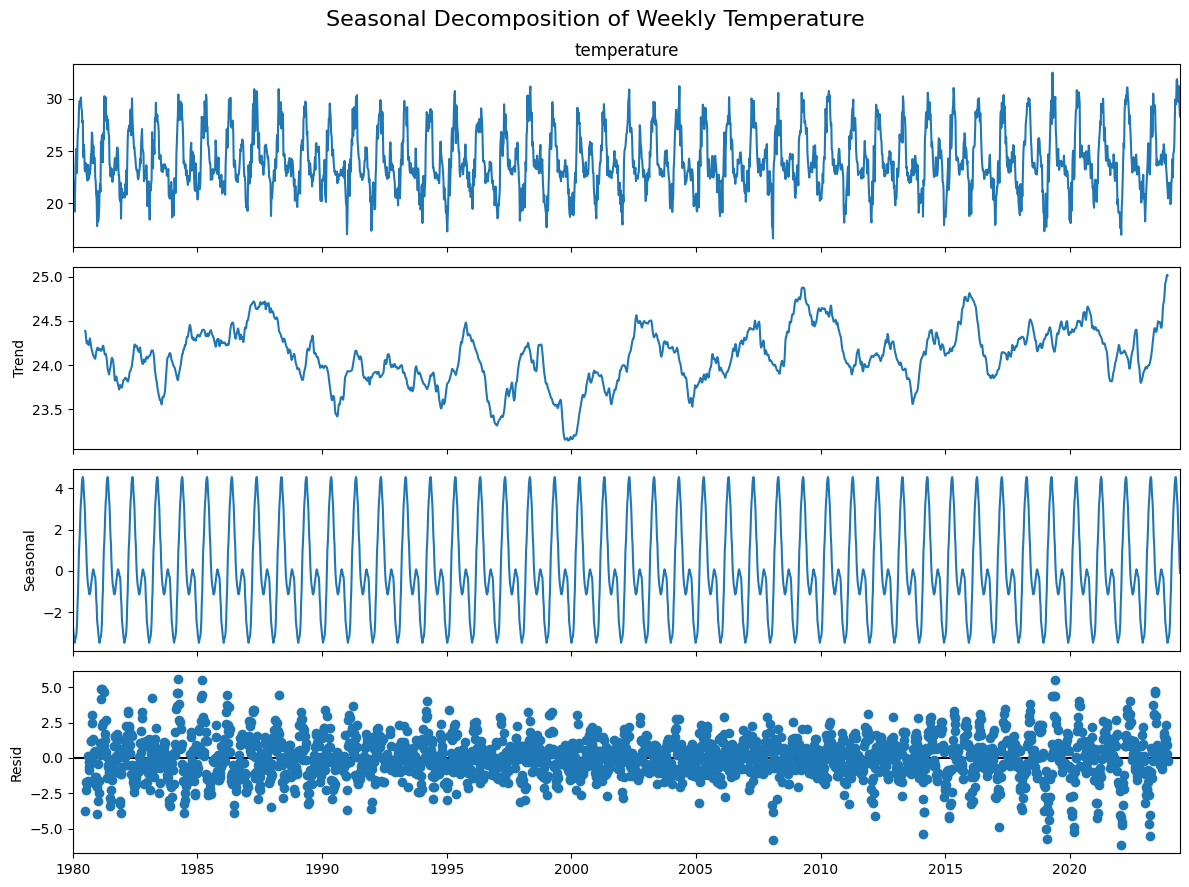

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(weekly_avg['temperature'], model='additive', period=52)

plt.rcParams.update({'figure.figsize': (12, 9)})
result.plot()
plt.suptitle('Seasonal Decomposition of Weekly Temperature', fontsize=16)
plt.tight_layout()
plt.show()

In [16]:
seasonal = result.seasonal

rng = (seasonal.max() - seasonal.min())
print(f"range: {rng:.2f}")

range: 8.05


<Axes: xlabel='month', ylabel='temperature'>

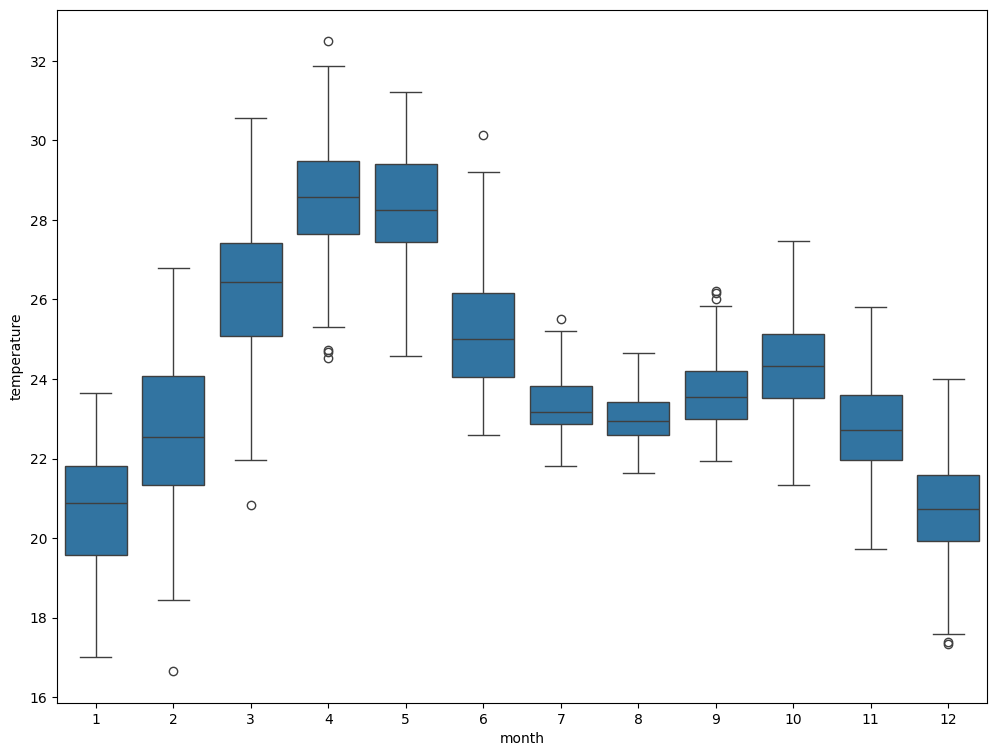

In [17]:
import seaborn as sns

weekly_avg['month'] = weekly_avg.index.month
sns.boxplot(x='month', y='temperature', data=weekly_avg)

#Part 2

##Differencing

In [18]:
#Remove seasonality of gym series using diff
weekly_mean_diff=weekly_avg.diff(periods=52)
weekly_mean_diff=weekly_mean_diff.dropna()

In [19]:
weekly_mean_diff_plt = weekly_mean_diff['temperature']
weekly_mean_diff_plt

,temperature
date,
1980-12-30,1.160119
1981-01-06,-3.630952
1981-01-13,-3.559524
1981-01-20,-1.408929
1981-01-27,1.767857
...,...
2024-05-07,-0.758333
2024-05-14,2.127381
2024-05-21,2.341667


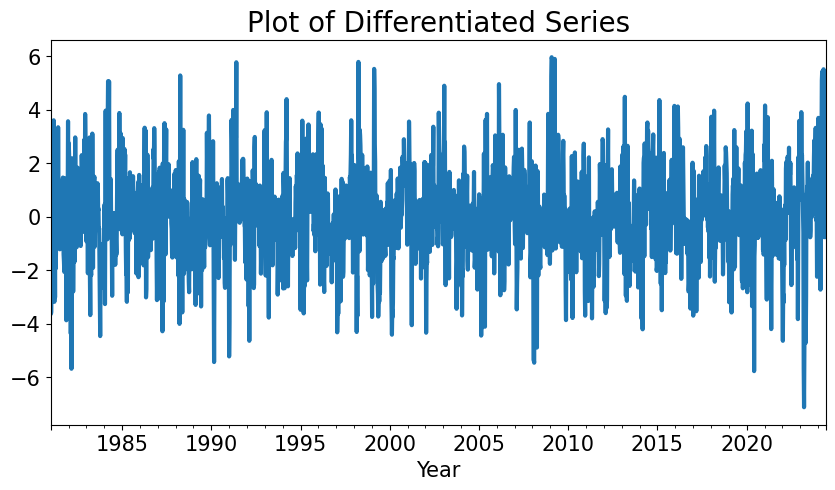

In [20]:
#plot series after removing seasonality
weekly_mean_diff_plt.plot(figsize=(10,5), linewidth=3, fontsize=15)
plt.title("Plot of Differentiated Series",fontsize=20)
plt.xlabel('Year', fontsize=15);

##Correlogram

<Figure size 1000x400 with 0 Axes>

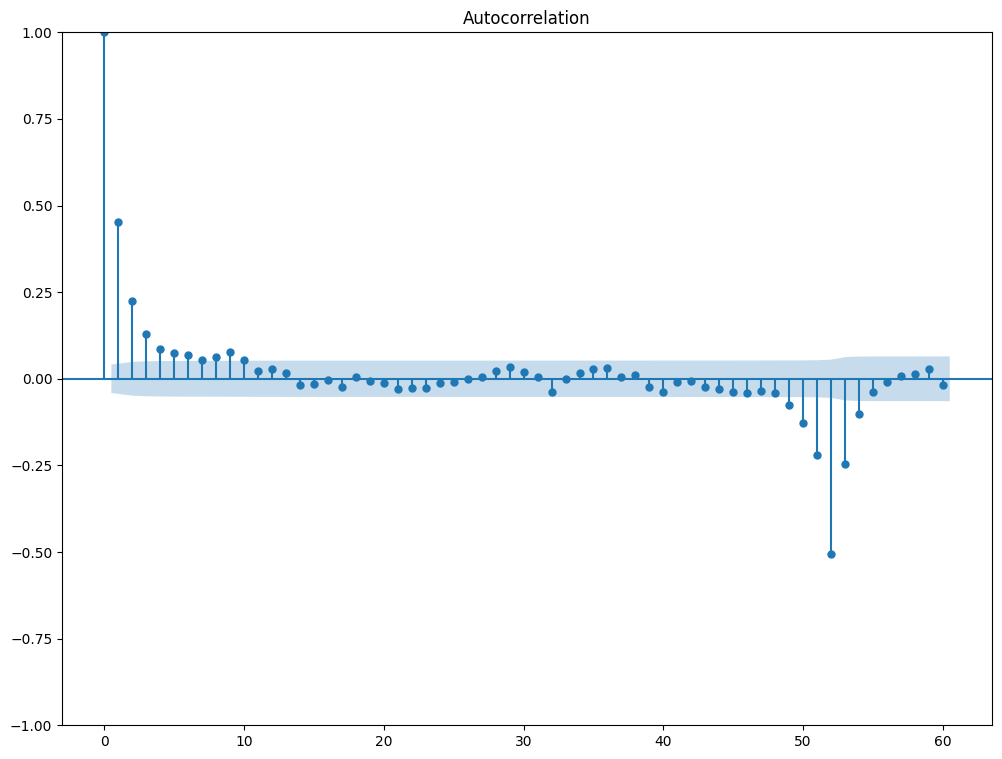

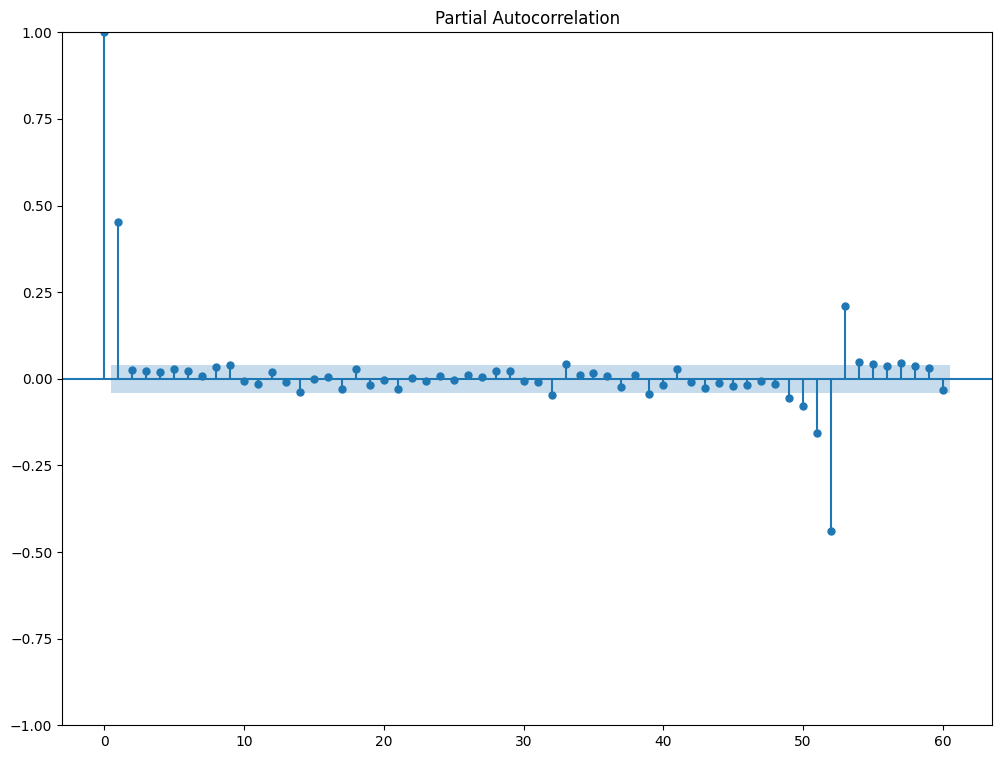

In [21]:
#plot autocorrelation for new series
plt.figure(figsize=(10, 4))
tsaplots.plot_acf(weekly_mean_diff_plt,lags=60);
tsaplots.plot_pacf(weekly_mean_diff_plt,lags=60);

##Train-Test

In [22]:
# Define the train-test split ratio
split_ratio = 0.8  # 80% for training, 20% for testing
data = weekly_avg['temperature']

# Calculate the split index
split_index = int(len(data) * split_ratio)

# Split the data
train_df = data.iloc[:split_index]
test_df = data.iloc[split_index:]

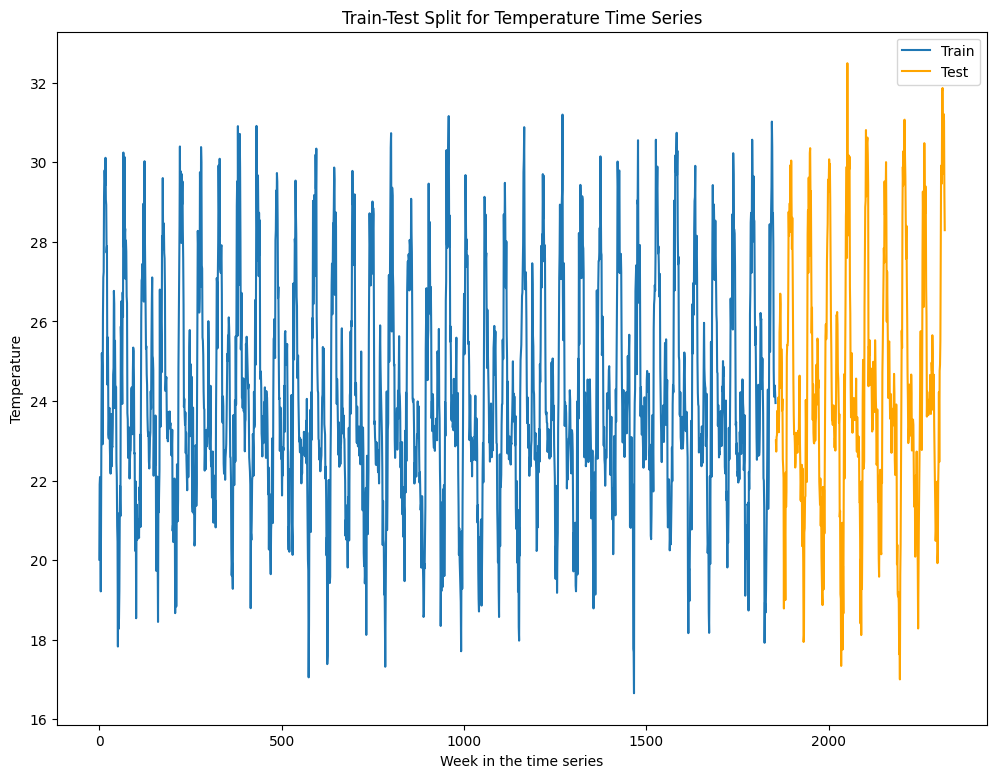

Train Data Shape: (1855,)
Test Data Shape: (464,)


In [23]:
# Plot the train-test split
plt.plot(np.arange(len(train_df)), train_df, label='Train')
plt.plot(np.arange(len(train_df), len(data)), test_df, label='Test', color='orange')
plt.xlabel('Week in the time series')
plt.ylabel('Temperature')
plt.title('Train-Test Split for Temperature Time Series')
plt.legend()
plt.show()

# Print shapes of splits
print("Train Data Shape:", train_df.shape)
print("Test Data Shape:", test_df.shape)

##Choose SARIMA Model

In [24]:
model_AR1Q0 = SARIMAX(train_df, order=(1, 1, 0),seasonal_order=(1, 1, 0, 52))
model_fit_AR1Q0 = model_AR1Q0.fit(disp=False)
print("BIC for odel AR(1) whit Q=0: ", model_fit_AR1Q0.bic)
print("AIC for odel AR(1) whit Q=0: ", model_fit_AR1Q0.aic)

model_AR1Q1 = SARIMAX(train_df, order=(1, 1, 0),seasonal_order=(1, 1, 1, 52))
model_fit_AR1Q1 = model_AR1Q1.fit(disp=False)
print("BIC for odel AR(1) whit Q=1: ", model_fit_AR1Q1.bic)
print("AIC for odel AR(1) whit Q=1: ", model_fit_AR1Q1.aic)

BIC for odel AR(1) whit Q=0:  6413.0187146404805
AIC for odel AR(1) whit Q=0:  6396.528757325976
BIC for odel AR(1) whit Q=1:  5996.981051159216
AIC for odel AR(1) whit Q=1:  5974.994441406543


##Fit & Evaluate

In [25]:
def fit_time_series_model(model_name, y_train, X_train=None, seasonal_periods=52):
    """
    Fits a time series forecasting model.

    Parameters:
        model_name (str): The name of the model to fit. Options: 'SARIMA', 'Exponential Smoothing', 'Prophet', 'Fourier'.
        y_train (array-like): Target variable for training.
        X_train (DataFrame or None): Optional exogenous variables for training.
        seasonal_periods (int): Seasonal period for models that require it.

    Returns:
        model: The fitted model.
    """
    if model_name == 'SARIMA':
        from statsmodels.tsa.statespace.sarimax import SARIMAX
        model = SARIMAX(y_train, exog=X_train,
                        order=(1,1,0), seasonal_order=(1,1,1,seasonal_periods),
                        enforce_stationarity=False, enforce_invertibility=False)
        fitted_model = model.fit()

    elif model_name == 'Exponential Smoothing':
        from statsmodels.tsa.holtwinters import ExponentialSmoothing
        model = ExponentialSmoothing(y_train, trend='add', seasonal='add', seasonal_periods=seasonal_periods)
        fitted_model = model.fit()

    elif model_name == 'Prophet':
        from prophet import Prophet
        df_train = y_train.reset_index()
        df_train.columns = ['ds', 'y']

        model = Prophet(yearly_seasonality=True)

        # If exogenous variables exist, add them as regressors
        if X_train is not None:
            for col in X_train.columns:
                model.add_regressor(col)
            df_exog = X_train.reset_index()
            df_train = pd.concat([df_train, df_exog[X_train.columns]], axis=1)

        model.fit(df_train)
        fitted_model = model
    else:
        raise ValueError(f"Model '{model_name}' is not supported.")

    return fitted_model


In [26]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_time_series_models(train_df, test_df, models_list, seasonal_periods=52):
    """
    Evaluate multiple time series models with or without exogenous variables.

    Parameters:
        train_df (pd.Series or pd.DataFrame): Training set (target or target + exogenous variables).
        test_df (pd.Series or pd.DataFrame): Testing set (target or target + exogenous variables).
        models_list (list): List of model names to evaluate.
        seasonal_periods (int): Seasonality period (default=52 for weekly seasonality).

    Returns:
        results_df (pd.DataFrame): DataFrame with RMSE and MAE results.
        forecasts (dict): Dictionary with model forecasts.
    """

    # Separate y (target) and X (exogenous variables) if necessary
    if isinstance(train_df, pd.DataFrame):
        if train_df.shape[1] > 1:
            y_train = train_df.iloc[:, 0]
            X_train = train_df.iloc[:, 1:]
            y_test = test_df.iloc[:, 0]
            X_test = test_df.iloc[:, 1:]
        else:
            y_train = train_df.squeeze()
            X_train = None
            y_test = test_df.squeeze()
            X_test = None
    else:
        y_train = train_df
        X_train = None
        y_test = test_df
        X_test = None

    results = []
    forecasts = {}

    for model_name in models_list:
        print(f"Training model: {model_name}")

        if model_name == 'SARIMA':
            model = SARIMAX(
                y_train,
                exog=X_train,
                order=(1, 1, 0),
                seasonal_order=(1, 1, 1, seasonal_periods),
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            model_fit = model.fit(disp=False)
            forecast = model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)

        elif model_name == 'Exponential Smoothing':
            model = ExponentialSmoothing(
                y_train,
                trend='add',
                seasonal='add',
                seasonal_periods=seasonal_periods
            )
            model_fit = model.fit()
            forecast = model_fit.forecast(len(y_test))

        elif model_name == 'Prophet':
            # Prophet requires a DataFrame with 'ds' and 'y' columns
            prophet_train = pd.DataFrame({'ds': y_train.index, 'y': y_train.values})
            prophet_test = pd.DataFrame({'ds': y_test.index})

            model = Prophet()

            # If exogenous variables exist, add them
            if X_train is not None:
                for col in X_train.columns:
                    prophet_train[col] = X_train[col].values
                    prophet_test[col] = X_test[col].values
                    model.add_regressor(col)

            model.fit(prophet_train)

            future = prophet_test
            forecast_prophet = model.predict(future)
            forecast = forecast_prophet['yhat'].values
        else:
            raise ValueError(f"Model '{model_name}' is not supported.")

        # Calculate errors
        rmse = np.sqrt(mean_squared_error(y_test, forecast))
        mae = mean_absolute_error(y_test, forecast)

        # Store results
        results.append({
            'Model': model_name,
            'RMSE': rmse,
            'MAE': mae
        })

        # Store forecast
        forecasts[model_name] = forecast

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    return results_df, forecasts

In [27]:
models_list = ['SARIMA', 'Exponential Smoothing', 'Prophet']

results_df, forecasts = evaluate_time_series_models(train_df, test_df, models_list)

print(results_df)


Training model: SARIMA
Training model: Exponential Smoothing
Training model: Prophet


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7ytzm22e/zeykfcsf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7ytzm22e/ic3g1mn0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80880', 'data', 'file=/tmp/tmp7ytzm22e/zeykfcsf.json', 'init=/tmp/tmp7ytzm22e/ic3g1mn0.json', 'output', 'file=/tmp/tmp7ytzm22e/prophet_modelyreelkkk/prophet_model-20250430132648.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:26:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:26:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


                   Model      RMSE       MAE
0                 SARIMA  2.159841  1.677419
1  Exponential Smoothing  1.790783  1.346335
2                Prophet  1.325594  1.061670


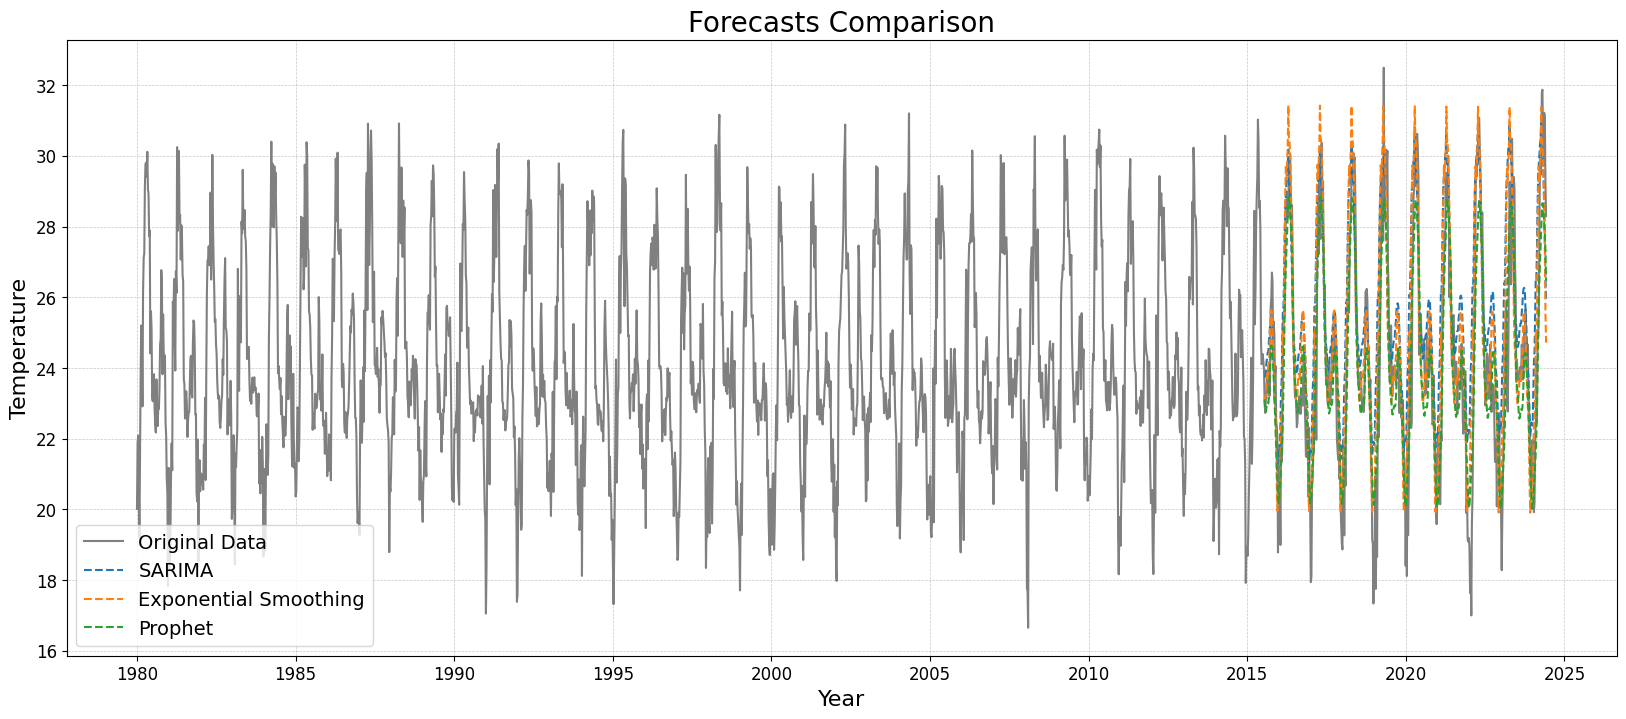

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

# Create the figure
plt.figure(figsize=(20, 8))

# Plot the original training + testing temperature data
full_data = pd.concat([train_df, test_df])
if isinstance(full_data, pd.DataFrame):
    plt.plot(full_data.index, full_data['temperature'], label='Original Data', color='grey')
else:
    plt.plot(full_data.index, full_data.values, label='Original Data', color='grey')

# Plot forecasts from each model
for model_name, forecast in forecasts.items():
    # If forecast is array, convert it to Series; if already Series, use it directly
    if isinstance(forecast, (np.ndarray, list)):
        forecast_series = pd.Series(forecast, index=test_df.index)
    else:
        forecast_series = forecast  # Already a Series

    plt.plot(forecast_series.index, forecast_series.values, label=model_name, linestyle='--')

# Add labels, title, legend, grid, and adjust fonts
plt.title('Forecasts Comparison', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Temperature', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

#Part 3

###Choose Exogenous Vriablse

In [29]:
weekly_avg.columns

Index(['date', 'temperature', 'relative_humidity', 'dew_point',
       'precipitation (mm)', 'rain (mm)', 'snowfall (cm)',
       'pressure_msl (hPa)', 'surface_pressure (hPa)', 'cloud_cover (%)',
       'cloud_cover_low (%)', 'cloud_cover_mid (%)', 'cloud_cover_high (%)',
       'vapour_pressure_deficit (kPa)', 'wind_speed_10m (km/h)',
       'wind_direction', 'is_Day', 'month'],
      dtype='object')

In [30]:
columns_to_corr = ['temperature', 'relative_humidity', 'dew_point',
       'precipitation (mm)', 'rain (mm)', 'pressure_msl (hPa)',
        'surface_pressure (hPa)', 'cloud_cover (%)',
       'cloud_cover_low (%)', 'cloud_cover_mid (%)', 'cloud_cover_high (%)',
       'vapour_pressure_deficit (kPa)', 'wind_speed_10m (km/h)', 'wind_direction']

data_ex = weekly_avg[columns_to_corr]

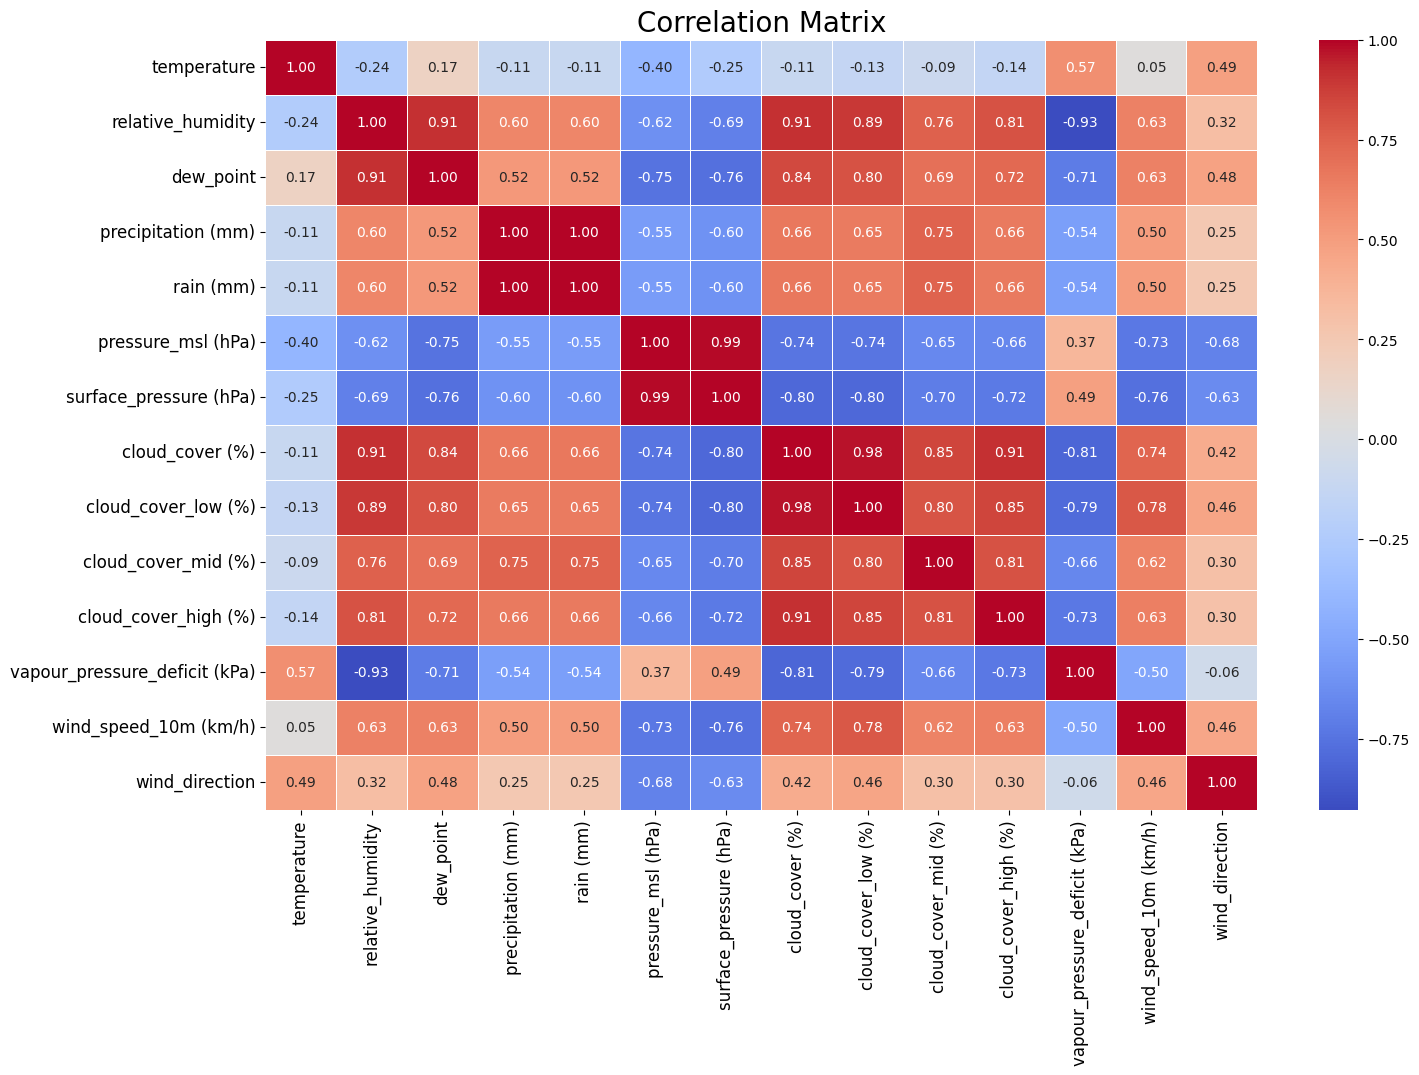

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
correlation_matrix = data_ex.corr()

# Plot the heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix', fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

##Train-Test

In [32]:
data_ex = weekly_avg[['temperature', 'vapour_pressure_deficit (kPa)']]

# Split the data
train_df_ex = data_ex.iloc[:split_index]
test_df_ex = data_ex.iloc[split_index:]

##Fit & Evaluate

In [33]:
results_df, forecasts = evaluate_time_series_models(
    train_df_ex,
    test_df_ex,
    models_list=['SARIMA', 'Exponential Smoothing', 'Prophet'])

print(results_df)

Training model: SARIMA
Training model: Exponential Smoothing


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7ytzm22e/wlr5_7vc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7ytzm22e/yroyio90.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18351', 'data', 'file=/tmp/tmp7ytzm22e/wlr5_7vc.json', 'init=/tmp/tmp7ytzm22e/yroyio90.json', 'output', 'file=/tmp/tmp7ytzm22e/prophet_model3i7ge1kd/prophet_model-20250430133207.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:32:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Training model: Prophet


13:32:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


                   Model      RMSE       MAE
0                 SARIMA  1.451715  1.140751
1  Exponential Smoothing  1.790783  1.346335
2                Prophet  0.898702  0.668012


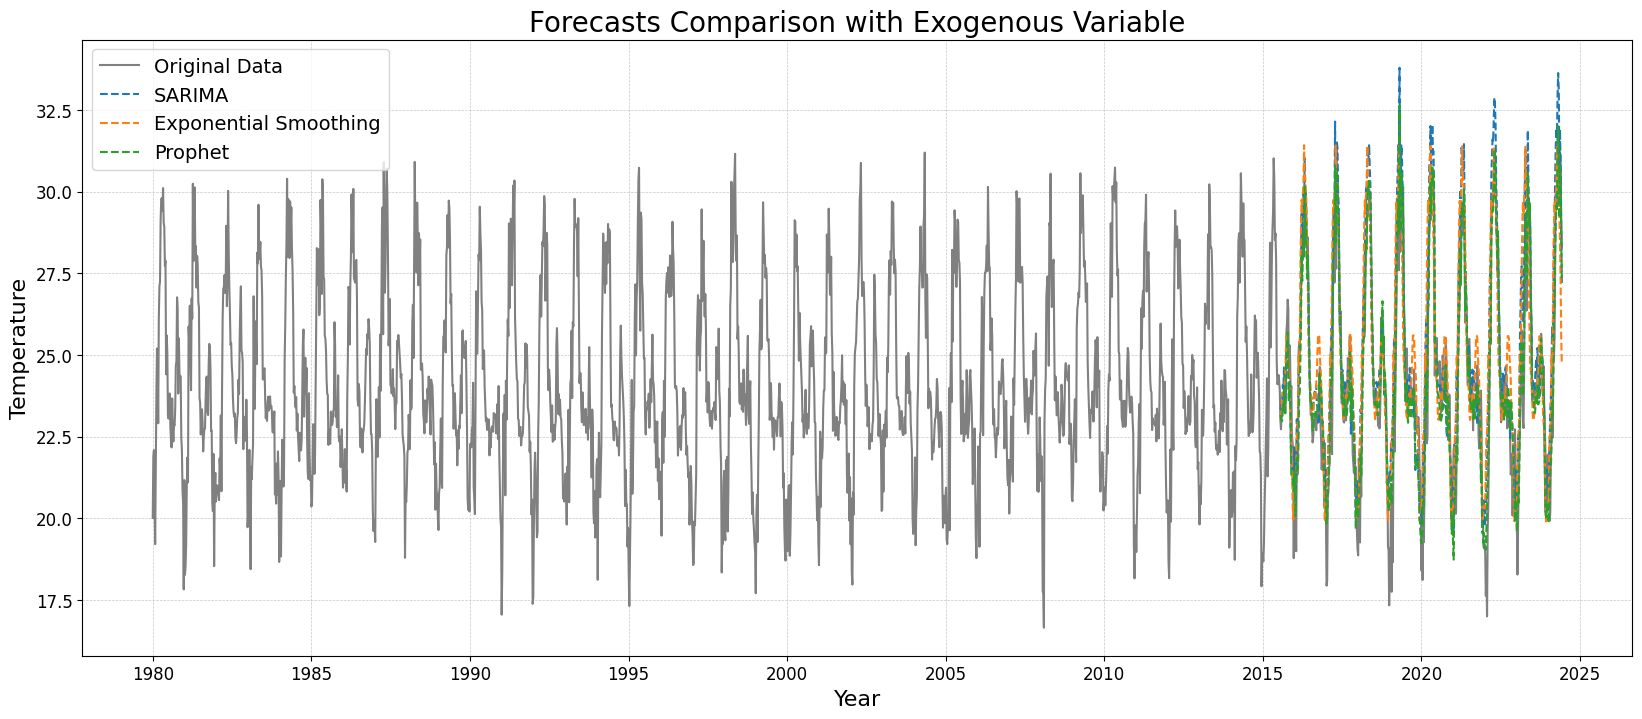

In [34]:
import matplotlib.pyplot as plt
import pandas as pd

# Create the figure
plt.figure(figsize=(20, 8))

# Plot the original training + testing temperature data
full_data = pd.concat([train_df, test_df])
if isinstance(full_data, pd.DataFrame):
    plt.plot(full_data.index, full_data['temperature'], label='Original Data', color='grey')
else:
    plt.plot(full_data.index, full_data.values, label='Original Data', color='grey')

# Plot forecasts from each model
for model_name, forecast in forecasts.items():
    # If forecast is array, convert it to Series; if already Series, use it directly
    if isinstance(forecast, (np.ndarray, list)):
        forecast_series = pd.Series(forecast, index=test_df.index)
    else:
        forecast_series = forecast  # Already a Series

    plt.plot(forecast_series.index, forecast_series.values, label=model_name, linestyle='--')

# Add labels, title, legend, grid, and adjust fonts
plt.title('Forecasts Comparison with Exogenous Variable', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Temperature', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

#Part 4

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7ytzm22e/0q2j76j_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7ytzm22e/md6xr7sd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42538', 'data', 'file=/tmp/tmp7ytzm22e/0q2j76j_.json', 'init=/tmp/tmp7ytzm22e/md6xr7sd.json', 'output', 'file=/tmp/tmp7ytzm22e/prophet_modelul1d204v/prophet_model-20250430133318.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:33:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:33:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


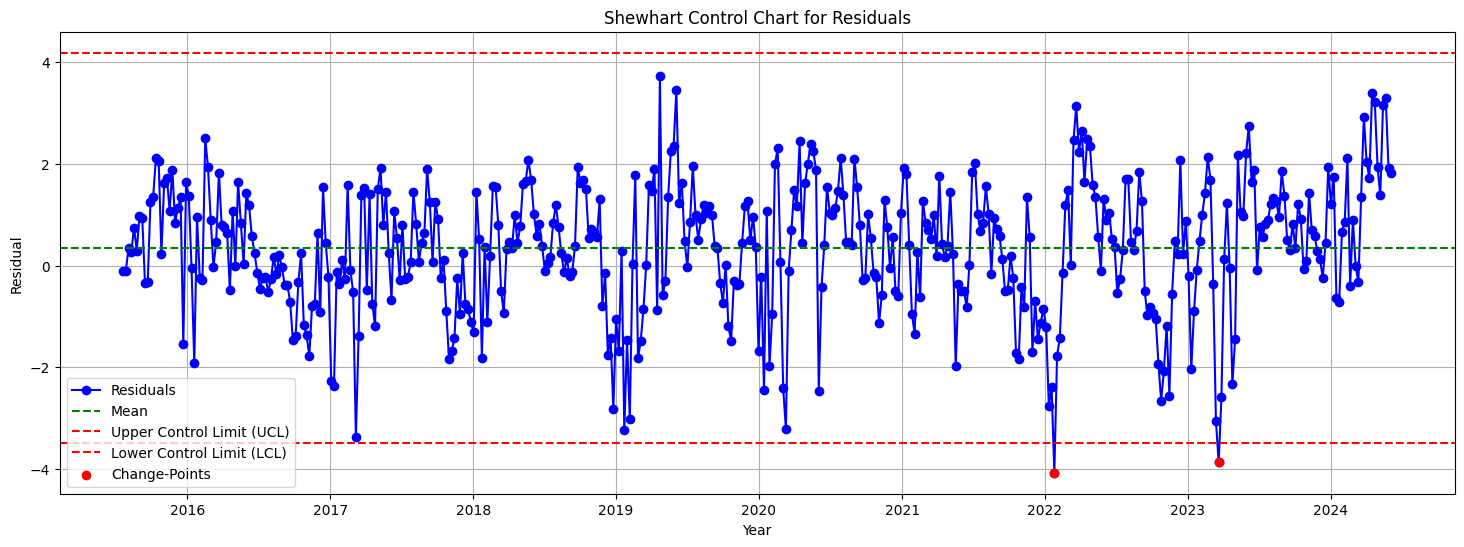

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Fit a model (using Prophet as example)
from prophet import Prophet

# Prepare the data in Prophet format
train_df_prophet = train_df.reset_index().rename(columns={'date': 'ds', 'temperature': 'y'})
test_df_prophet = test_df.reset_index().rename(columns={'date': 'ds', 'temperature': 'y'})

model = Prophet()
model.fit(train_df_prophet)

# Step 2: Predict on test set
forecast = model.predict(test_df_prophet)
y_pred = forecast['yhat'].values
y_true = test_df_prophet['y'].values

# Step 3: Calculate residuals
residuals = y_true - y_pred

# Step 4: Calculate control limits for Shewhart chart
mean_res = np.mean(residuals)
std_res = np.std(residuals)

ucl = mean_res + 3 * std_res  # Upper Control Limit
lcl = mean_res - 3 * std_res  # Lower Control Limit

# Step 5: Detect points outside control limits (potential change-points)
anomalies = (residuals > ucl) | (residuals < lcl)

# Step 6: Plot residuals and control limits
plt.figure(figsize=(18, 6))
plt.plot(test_df.index, residuals, label='Residuals', marker='o', color='blue')
plt.axhline(mean_res, color='green', linestyle='--', label='Mean')
plt.axhline(ucl, color='red', linestyle='--', label='Upper Control Limit (UCL)')
plt.axhline(lcl, color='red', linestyle='--', label='Lower Control Limit (LCL)')

# Mark anomalies
plt.scatter(test_df.index[anomalies], residuals[anomalies], color='red', label='Change-Points', zorder=5)

plt.title('Shewhart Control Chart for Residuals')
plt.xlabel('Year')
plt.ylabel('Residual')
plt.legend()
plt.grid(True)
plt.show()

In [44]:
y_true_series = pd.Series(y_true, index=test_df.index)
anomaly_dates = y_true_series.index[anomalies]

print("Detected anomaly dates and temperature values:")
for date in anomaly_dates:
    print(f"Date: {date}, Temperature: {y_true_series.loc[date]:.2f}")

Detected anomaly dates and temperature values:
Date: 2022-01-25 00:00:00, Temperature: 17.00
Date: 2023-03-21 00:00:00, Temperature: 22.77


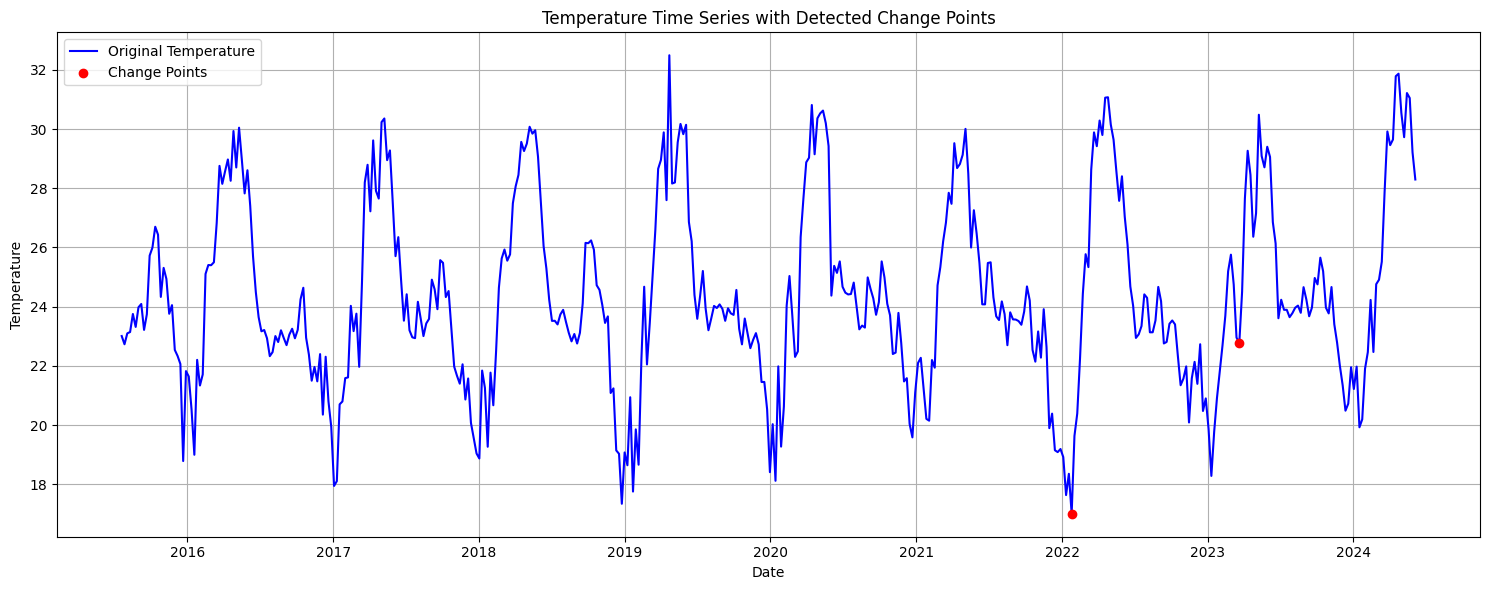

In [45]:
import matplotlib.pyplot as plt

if isinstance(anomalies, np.ndarray) and anomalies.dtype == bool:
    change_point_indices = np.where(anomalies)[0]
else:
    change_point_indices = anomalies

change_point_dates = y_true_series.index[change_point_indices]
change_point_values = y_true_series.iloc[change_point_indices]

plt.figure(figsize=(15, 6))
plt.plot(y_true_series.index, y_true_series.values, label="Original Temperature", color='blue')
plt.scatter(change_point_dates, change_point_values, color='red', label="Change Points", zorder=5)
plt.title("Temperature Time Series with Detected Change Points")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()